# Going Deeper 12. 직접 만들어보는 OCR

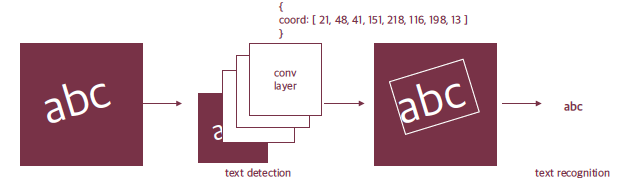

우리가 만들고자 하는 OCR은 이미지 속에서 영문을 Bounding box로 찾아내고 그 Bounding box 내에 어떤 Text가 포함되는지 알 수 있는 시스템이다. 

## Dataset for OCR

- OCR은 데이터셋에 필요한 텍스트 정보를 사람이 직접 입력해야 하는 번거로움이 있다.
- 따라서 OCR 데이터를 대량으로 만들려면 큰 비용이 든다.
- 데이터 문제를 해결하기 위한 방법 중 하나로는 컴퓨터로 대량 문자 이미지 데이터를 만들어내는 방법이다.

## 0. 데이터 준비

<준비물>  
- mkdir -p ~/aiffel/ocr  
- ln -s ~/data ~/aiffel/ocr/data

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


## 1. Recognition model (1)

Text recognition 모델을 직접 만들어보도록 하겠습니다. Recognition 모델은 2015년에 발표된 아래 논문에서 처음 소개된 CRNN 구조를 활용해서 만들어보도록 합시다.

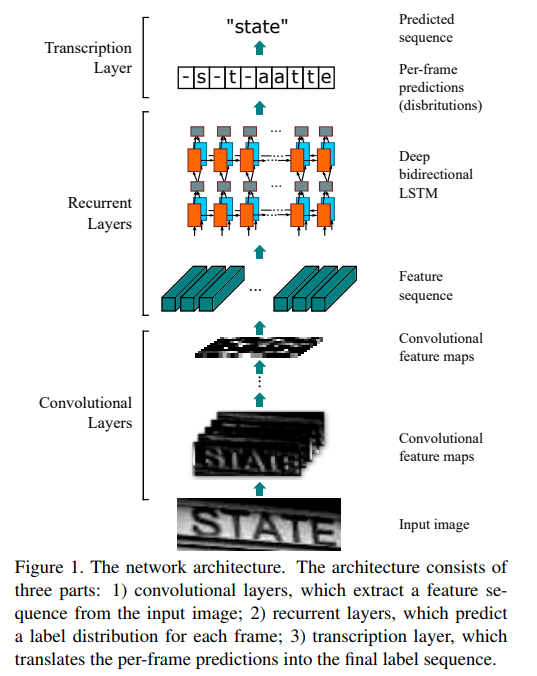

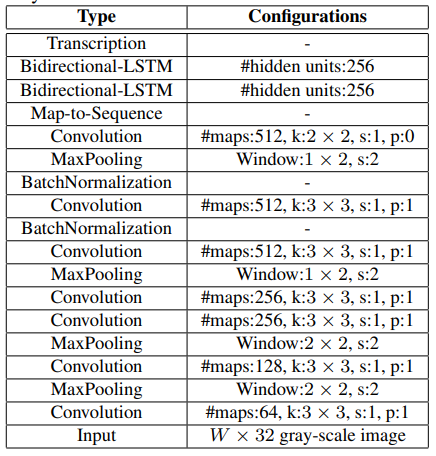

- CRNN의 구조를 살펴보기 위해 아래 Input image부터 보면 됩니다. 입력 이미지를 Conv layer를 통해 Feature를 추출하여 feature를 얻어냅니다.
- Recurrent Layers는 추출된 feature의 전체 context를 파악하고 다양한 output 크기에 대응이 가능합니다.
- 마지막으로 Transcription layer(Fully connected layer)는 step마다 어떤 character의 확률이 높은지 예측합니다.

몇 개의 Class가 필요한지 확인하기 위해 다음 셀을 실행한 후 퀴즈를 풀어보자!

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


lmdb를 이용할 예정  
LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자이다. 오늘 우리가 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있다!!  

<다운코드>
- $ pip install lmdb

In [3]:
## 필요한 라이브러리 import

import re
import six
import math
import lmdb
import copy
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

## 다운로드 한 MJ 데이터셋의 위치도 확인해보자!

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


## 2. Recognition model (2) Input Image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


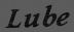

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


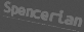

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


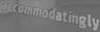

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


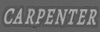

In [4]:
from IPython.display import display

## env에 데이터를 불러오겠다!!
## lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적임

env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

## 불러온 데이터를 txn(transaction)이라는 변수를 통해 연다.
## 이제 txn변수를 통해 직접 데이터에 접근 할 수 있음

with env.begin(write=False) as txn:
    for index in range(1, 5):
        
        ## index를 이용해서 라벨 키와 이미지 키를 만들면
        ## txn에서 라벨과 이미지를 읽어올 수 있다.
        
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        ## 이미지는 버퍼를 통해 읽어오기 때문에 
        ## 버퍼에서 이미지로 변환하는 과정이 다시 필요하다.
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        ## 원본 이미지 크기를 출력해 보자!
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        ## 이미지 비율을 유지하면서 높이를 32로 바꿀거임
        ## 하지만 너비를 100보다는 작게하고 싶다!!!
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        ## 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있다!
        
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

위에 결과값을 보면!! 이미지의 height 는 대부분이 31, 최대 32이고!   
width 는 문자열 길이에 따라서 다양한 것으로 보인다.

이제는 lmdb를 활용하여 케라스 모델 학습용 MJSynth데이터셋 클래스를 구현

In [5]:
class MJDatasetSequence(Sequence):
    
    ## 객체를 초기화 할 때 lmdb를 열어 env에 준비
    ## lmdb에 있는 데이터 수를 미리 파악
    
    def __init__(self, 
                 dataset_path,        ## dataset_path 는 읽어들일 데이터셋의 경로이다.
                 label_converter,    ## label_converter 는 아래에서 러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현하도록 한다.
                 batch_size=1,
                 img_size=(100,32),  ## 입력이미지 크기
                 max_text_len=22,    ## 필터링을 위한 최대 글자 수
                 is_train=False,     
                 character='') :     ## 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있다!
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    ## index에 해당하는 image와 label을 읽어온다.
    ## 위에서 사용한 코드와 매우 유사
    ## label을 조금 더 다듬는 것이 다름
    
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            ## label을 약간 더 다듬는다.
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    ## __getitem__ 은 약속되어 있는 메서드임
    ## 이 부분을 작성하면 slice 할 수 있음
    ## 자세한 내용 아래 문서 참고
    ## https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    ##
    ## 1. idx에 해당하는 index_list만큼 데이터를 불러옴
    ## 2. image와 label을 불러옴
    ## 3. 사용하기 좋은 inputs과 outputs 형태로 반환함
    def __getitem__(self, idx):
       
        ## 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        ## 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            ## 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있다.
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        ## 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

위 분석코드처럼 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 _get_img_label() 메소드에 반영됨. model.fit()에서 호출되는 __getitem__() 메소드에서 배치 단위만큼 _get_img_label()을 통해 가져온 dataset을 return함. _get_img_label()을 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지 맞춤

## 3. Recognition model (3) Encode

OCR 모델 학습데이터에 왜 공백 문자가 포함되어야 하는지는 다음 스텝에서 설명할 예정이다. 

In [6]:
class LabelConverter(object):
    
    def __init__(self, character):
        self.character="-" + character
        self.label_map = dict()
        
        for i, char in enumerate(self.character):
            self.label_map[char]=i
            
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i-1]:
                encoded_label.append(0) 
                ## 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])    
        return np.array(encoded_label)
    
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label
    
print("슝💨")

슝💨


In [7]:
## 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인하기
label_converter = LabelConverter(TARGET_CHARACTERS)

encoded_text = label_converter.encode('HELLO')
print('Encoded_text:', encoded_text)
decoded_text = label_converter.decode(encoded_text)
print('Decoded_text:', decoded_text)

Encoded_text: [ 8  5 12  0 12 15]
Decoded_text: HEL-LO


위에 결과값을 보면 동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함된 것을 확인할 수 있다.

## 4. Recognition model (4) Build CRNN model

- 이제 입력과 출력을 준비했으니 모델을 만들어볼 차례
- Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만들어두었다/

In [8]:
## CTC loss를 계산하기 위한 Lambda 함수

def ctc_lambda_func(args): 
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

print("슝💨")

슝💨


이제, K.ctc_batch_cost()를 활용하여, image_input을 입력으로, 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 build_crnn_model()을 구현해 보자!!!

In [9]:
## K.ctc_batch_cost()를 활용하여
## image_input을 입력, 마지막 Label을 'output'으로 출력하는 layer를 갖도록
## 모델을 만드는 함수 build_crnn_model()을 구현


def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    ## Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

print("슝💨")

슝💨


## 5. Recognition model (5) Train & Inference

이제 앞에서 정의한 MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜보자!

In [11]:
## 데이터셋과 모델을 준비
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

## 모델을 컴파일
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
## 훈련이 빨리 끝날 수 있도록 
##ModelCheckPoint와 EarlyStopping을 사용

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=100,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/100
565/565 [==============================] - 100s 155ms/step - loss: 25.0575 - val_loss: 23.9427

Epoch 00001: val_loss improved from inf to 23.94272, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/100
565/565 [==============================] - 88s 155ms/step - loss: 13.1217 - val_loss: 8.8122

Epoch 00002: val_loss improved from 23.94272 to 8.81218, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/100
565/565 [==============================] - 86s 153ms/step - loss: 6.6399 - val_loss: 6.2196

Epoch 00003: val_loss improved from 8.81218 to 6.21957, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/100
565/565 [==============================] - 85s 151ms/step - loss: 4.8512 - val_loss: 5.1076

Epoch 00004: val_loss improved from 6.21957 to 5.10756, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/100
565/565 [==============================] - 85s 151ms/step - loss: 3.8698 - val_loss: 4.5869

Epoch 00005: val_loss

이제 학습된 모델을 테스트셋을 통해 확인해 볼 차례

In [13]:
## 데이터셋과 모델을 불러온다.
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

## crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없다.
## 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들것이다.
## inference 전용 모델
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

학습된 모델의 성능을 눈으로 확인해보자!!

Result: 	 SLINKING9999999999999999


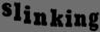

Result: 	 ALEPPO99999999999999999


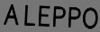

Result: 	 RWANDA999999999999999999


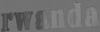

Result: 	 NATHANS99999999999999999


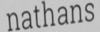

Result: 	 KALLBO99999999999999999


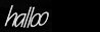

Result: 	 HURLS9999999999999999999


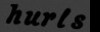

Result: 	 DOWNSIZE9999999999999999


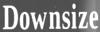

Result: 	 ROBOTIC99999999999999999


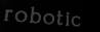

Result: 	 SLOPPY99999999999999999


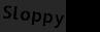

Result: 	 HERMITE99999999999999999


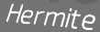

In [14]:
from IPython.display import display

## 모델이 inference한 결과를 글자로 바꿔주는 역할을 함
## 코드 하나하나를 이해하기는 조금 어려울 수 있다.
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

## 모델과 데이터셋이 주어지면 inference를 수행함
## index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
## 결과를 디코딩해 출력해준다.

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# 프로젝트: End-to-End OCR

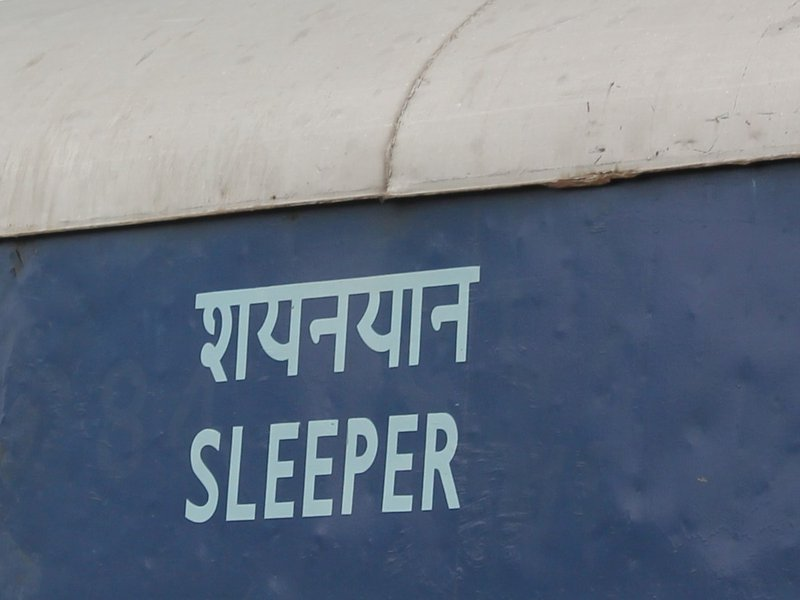

- keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠다.
- 이를 위해서 keras-ocr을 설치해주고 Detector를 만들어보자!

### 데이터 다운로드(☁️클라우드 유저용)

In [15]:
import cv2
import matplotlib.pyplot as plt
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = os.path.join(HOME_DIR+'/data/', 'sample.jpg')

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


- 미션 : 이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어보세요! inference한 후에는 이를 시각화하도록 합니다. 단어의 영역을 잘라오도록 해주세요.

#### 이게 에러코드.... 이 함수가 뭐가 잘못되어서 밑에서 호출을 하니까 계속 에러가 떴다.. 거의 한 50번정도 실행을 한 듯ㅋㅋㅋㅋㅋ

In [81]:
def detect_text(img_path):
    ## 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경
    ## 배치의 첫 번째 결과만 가져온다.
    ## 시각화를 위해서 x와 y좌표를 변경해준다. (앞선 h dimension으로 인해 y,x로 표기됨)
    img = cv2.imread(img_path)
    line_img = img.copy()
    input_img = img[tf.newaxis,...]
    result = detector.detect(input_img)
    ocr_result = result[0]
    
    cropped_imgs = []
    
    for text_result in ocr_result:
        text_result = text_result.astype(np.int16)
        for i in range(4):
            if i==3:
                line_img = cv2.line(line_img,tuple(text_result[3]),tuple(text_result[0]),(0,0,255),10)
            else:
                line_img = cv2.line(line_img,tuple(text_result[i]),tuple(text_result[i+1]),(0,0,255),10)
        
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        cropped_imgs.append(img[int(y_min):int(y_max),int(x_min):int(x_max)])
    
    return line_img, cropped_imgs

- 미션 : 이제 위에서 이미지 내의 단어 이미지를 얻었습니다. 그럼 Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보세요!

In [82]:
def recognize_img(input_img, input_img_size=(100,32)):
    ## 잘려진 단어 이미지를 인식하는 코드
    img = input_img[:,:,::-1]
    img = cv2.resize(img, input_img_size)
    result_img = img.copy()
    img = img.transpose(1,0,2)
    img = img[tf.newaxis,...]
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(result_img.astype(np.uint8)))

In [83]:
## 위에서 적은거 처럼 detect_text 이 함수가 이상하니까 호출하니까 
## 계속해서 에러가 떴다ㅜㅜ

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

array([[[209, 214, 213],
        [206, 211, 210],
        [202, 207, 206],
        ...,
        [178, 182, 187],
        [178, 182, 187],
        [181, 185, 190]],

       [[184, 189, 188],
        [183, 188, 187],
        [181, 186, 185],
        ...,
        [178, 182, 187],
        [177, 181, 186],
        [178, 182, 187]],

       [[171, 176, 175],
        [171, 176, 175],
        [172, 177, 176],
        ...,
        [179, 183, 188],
        [180, 184, 189],
        [183, 187, 192]],

       ...,

       [[103,  77,  60],
        [105,  79,  62],
        [106,  80,  63],
        ...,
        [101,  73,  56],
        [102,  74,  57],
        [102,  74,  57]],

       [[104,  78,  61],
        [105,  79,  62],
        [107,  81,  64],
        ...,
        [102,  74,  57],
        [103,  75,  58],
        [103,  75,  58]],

       [[103,  77,  60],
        [105,  79,  62],
        [107,  81,  64],
        ...,
        [102,  74,  57],
        [103,  75,  58],
        [104,  76,  59]]

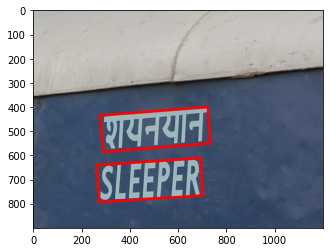

In [84]:
plt.imshow(img[:,:,::-1])

In [85]:
def recognize_img(input_img, input_img_size=(100,32)):
    ## 잘려진 단어 이미지를 인식하는 코드
    img = input_img[:,:,::-1]
    img = cv2.resize(img, input_img_size)
    result_img = img.copy()
    img = img.transpose(1,0,2)
    img = img[tf.newaxis,...]
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(result_img.astype(np.uint8)))

Result: 	 RARIER999999999999999999


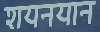

Result: 	 SLEEPER9999999999999999


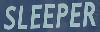

In [86]:
for _img in cropped_img:
    recognize_img(_img)

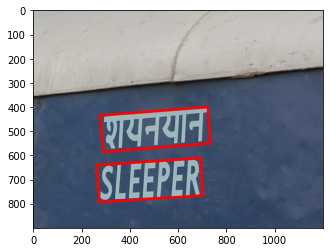

In [87]:
SAMPLE_IMG_PATH = os.path.join(HOME_DIR+'/data/', 'sample.jpg')
img, cropped_img = detect_text(SAMPLE_IMG_PATH)
plt.imshow(img[:,:,::-1])

Result: 	 RARIER999999999999999999


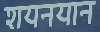

Result: 	 SLEEPER9999999999999999


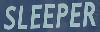

In [88]:
for _img in cropped_img:
    recognize_img(_img)

# <회고 ! >

## <어려웠던 점>  

- OpenCV 4.5 2 1: error: (-5:Bad argument) in function imshow Overload resolution failed

자꾸 이 에러가 떴다.. 첨에는 이 에러가 왜 뜨는지 구글링을 해도 정확히 같은 에러가 없어서 어려웠다..근데 계속 찾아보고 진짜 시간을 많이 투자했더니 type 형이 안 맞아서 오류가 뜬 것이었다.. 그래서 int형으로 바꿔줘야하는 것은 알겠는데.. 정확히 어느 부분인지 알 수가 없었다... 그래서 고민을 많이 하고 구글링을 많이 해서 혼자서 해결을 했다!!! 

text_result = text_result.astype(np.int16)  
에러코드에 저걸 추가해줬는데 에러가 뜨지 않고 잘 돌아갔다!! 

- 원인
    - 위 명령어는 OpenCV-python를 사용할 때, resize 명령어로 이미지 크기를 조절할때 발생하는 명령어이다. 
    - 원인은 이미지의 shape이 맞지 않거나, 이미지(Array)의 Type이 맞지 않아서 발생함

- 에러 잡는 법 
    - img.shape을 print하여 None 타입이 아닌지를 확인
    - img의 Type이 Python의 기본 int인 경우에 발생함. 그럴 경우 아래와 같이 Type을 uint8 or 16, int16으로 바꿔주면 정상적으로 Resize가 된다. 픽셀 값의 범위가 0 ~ 255가 아니라 0~1인 경우 np.float32를 주면 된다.

- 코드 
    - img = img.astype(np.uint8) # 8, 16
    - img = img.astype(np.int16)

In [1]:
## 에러코드  

"""
def detect_text(img_path):
    img = cv2.imread(img_path)
    line_img = img.copy()
    input_img = img[tf.newaxis,...]
    result = detector.detect(input_img)
    ocr_result = result[0]
    
    cropped_imgs = []
    
    for text_result in ocr_result:
        text_result = text_result.astype(np.int16)
        for i in range(4):
            if i==3:
                line_img = cv2.line(line_img,tuple(text_result[3]),tuple(text_result[0]),(0,0,255),10)
            else:
                line_img = cv2.line(line_img,tuple(text_result[i]),tuple(text_result[i+1]),(0,0,255),10)
        
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        cropped_imgs.append(img[int(y_min):int(y_max),int(x_min):int(x_max)])
    
    return line_img, cropped_imgs
"""

'\ndef detect_text(img_path):\n    img = cv2.imread(img_path)\n    line_img = img.copy()\n    input_img = img[tf.newaxis,...]\n    result = detector.detect(input_img)\n    ocr_result = result[0]\n    \n    cropped_imgs = []\n    \n    for text_result in ocr_result:\n        text_result = text_result.astype(np.int16)\n        for i in range(4):\n            if i==3:\n                line_img = cv2.line(line_img,tuple(text_result[3]),tuple(text_result[0]),(0,0,255),10)\n            else:\n                line_img = cv2.line(line_img,tuple(text_result[i]),tuple(text_result[i+1]),(0,0,255),10)\n        \n        x_min = text_result[:,0].min() - 5\n        x_max = text_result[:,0].max() + 5\n        y_min = text_result[:,1].min() - 5\n        y_max = text_result[:,1].max() + 5\n        cropped_imgs.append(img[int(y_min):int(y_max),int(x_min):int(x_max)])\n    \n    return line_img, cropped_imgs\n'

## <알게된 점> & <아직까지 모호한 점>  
저번에 익스를 공부할 때 OCR 에 대해서 배웠다, 근데 그때 너무 급하게 대충 공부를 해서 그런지 원리는 알겠는데 구현하고 모델링하는 것이 너무 어려웠다. 이번에는 모델은 달랐지만 그래도 OCR 에 대해서 다시 배울 수 있어서 좋았다. 모델 추론 결과를 확인해보니 영어는 대부분 정확하게 인식되었다는 것을 알 수 있었고, 
'sample1' 테스트 결과, text detection과 recognition이 잘 된 것을 알 수 있었다. 그리고 각도가 변경된 이미지의 경우 text detection은 잘 되지만 recognition이 잘 안 되는 결과를 볼 수 있었다. 근데 아직 모호한 점은 문자 뒤에 나오는 공백이 9999999...로 나오는데 왜 그런지 모르겠다..ㅜ

## <자기 다짐>  
뭔가 에러가 떴을 때 다른 사람의 코드를 참고해서 고치거나 구글링을 하는 편인데 이번에는 명확히 똑같은 에러가 뜬 코드를 보지도 못했고 구글링을 해서 원인을 알아내니 혼자서 해보고 싶어서 시간은 걸렸지만 낑낑되면서 했다. 그러니까 저 에러에 대해서 완벽히 !! 는 아니지만 완전 잘 이해가 되었다. 그리고 에러를 잡는 법 다양한 방법을 시도하면서 공부가 더 잘 된 것 같다! 내가 아는 에러는 정말 극소수이고 ... 아주 많은 이상한 에러가 많은 것 같다.. 에러가 뜨면 스트레스 부터 받는데 그냥 이번처럼 오래걸려도 이렇게 찾아보는게 더 도움이 되고 좋은 것 같다! 나는 이 노드나 코드를 완벽하게 보는 것이 아니라 !! 하나라도 나에게 도움 되는 개념이나 용어를 마스터 하는 것이다!! 화이팅~~